# Examen des prédictions du modèle estimé par apprentissage de transfert sur les séquences de test

## Estimation par solution exacte des équations d'estimation

In [24]:
import json
import numpy as np
import pandas as pd
import sklearn

In [6]:
import h5py
import cooler

In [27]:
import matplotlib.pyplot as plt

In [7]:
predpath = "/home/bureau/projects/def-bureau/bureau/ran-donnees/PredictNeuronHi-C/akita_pred_sans_final_test_lisse/"
predfile = predpath + "preds.h5"

In [8]:
pred = h5py.File(predfile, 'r')
pred

<HDF5 file "preds.h5" (mode r)>

In [9]:
pred.keys()

<KeysViewHDF5 ['preds']>

In [10]:
pred['preds'].shape

(6668, 99681, 48)

In [11]:
targetfile = "/home/bureau/projects/def-bureau/bureau/distiller/iPSC/data/1s/seqs_cov/0.h5"

In [12]:
targets = h5py.File(targetfile, 'r')
targets

<HDF5 file "0.h5" (mode r)>

In [15]:
# Les données de tests sont les 6667 (pred['preds'].shape[0]) dernières
test_targets = targets['targets'][targets['targets'].shape[0]-pred['preds'].shape[0]:,]

In [16]:
test_targets.shape

(6668, 99681)

## Calcul des prédictions

In [12]:
# Lecture des betas
beta_dat = pd.read_csv("beta_final.csv",index_col=0)

In [13]:
beta_dat

,0
0,-0.151719
1,0.025881
2,0.011916
3,0.002939
4,-0.066120
5,-0.009600
6,0.021476
7,-0.011937
8,-0.016037
9,-0.016115


In [14]:
X = np.array(pred['preds'][0,:pred['preds'].shape[1],:pred['preds'].shape[2]])
X.shape

(99681, 48)

In [15]:
import statsmodels.api as sm

In [23]:
X = sm.add_constant(X)
X

array([[ 1.00000000e+00,  1.56982422e-01,  3.10302734e-01, ...,
         4.25048828e-01, -5.00202179e-04, -8.11767578e-03],
       [ 1.00000000e+00,  1.47949219e-01,  2.95898438e-01, ...,
         4.27246094e-01,  1.03988647e-02, -1.21116638e-03],
       [ 1.00000000e+00,  1.34399414e-01,  2.81982422e-01, ...,
         4.27246094e-01,  1.14288330e-02,  4.21142578e-03],
       ...,
       [ 1.00000000e+00,  7.95288086e-02,  2.69042969e-01, ...,
         4.41894531e-01, -2.69287109e-01,  1.20258331e-03],
       [ 1.00000000e+00,  8.02612305e-02,  2.62939453e-01, ...,
         4.38964844e-01, -2.60742188e-01,  1.01470947e-02],
       [ 1.00000000e+00,  8.30078125e-02,  2.64160156e-01, ...,
         4.33837891e-01, -2.67822266e-01, -8.34465027e-04]])

In [24]:
tmp = np.dot(X,beta_dat)
tmp.shape

(99681, 1)

In [16]:
pred_final = np.zeros((pred['preds'].shape[0],pred['preds'].shape[1]))
for j in range(pred['preds'].shape[0]):
    X = np.array(pred['preds'][j,:pred['preds'].shape[1],:pred['preds'].shape[2]])
    X = sm.add_constant(X)
    pred_final[j,] = np.dot(X,beta_dat)[:,0]

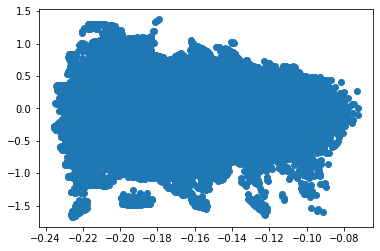

In [17]:
plt.scatter(pred_final[1,:], test_targets[1,:])
plt.show()

## Calcul de l'erreur quadratique moyenne par lignée cellulaire utilisée pour la prédiction

In [18]:
from sklearn.metrics import mean_squared_error
mse_transfer = mean_squared_error(test_targets,pred_final[:,:])

In [19]:
display(mse_transfer)

0.32098996497480603

## Calcul de l'erreur quadratique moyenne pour chaque séquence de 1Mb

In [32]:
mse_transfer_seq = np.zeros(pred_final.shape[0])
for j in range(pred_final.shape[0]):
    mse_transfer_seq[j] = mean_squared_error(test_targets[j,],pred_final[j,])

In [33]:
mse_transfer_dat = pd.DataFrame(mse_transfer_seq)
mse_transfer_dat.to_csv("mse_transfer.csv")

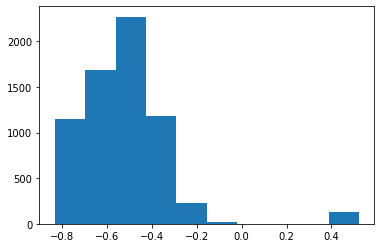

In [34]:
plt.hist(np.log10(mse_transfer_seq))
plt.show()

## Sauvegarde des prédictions

In [20]:
hf = h5py.File('pred_final.h5', 'w')
hf.create_dataset('pred_final',data=pred_final)
hf.close()

In [18]:
predf = h5py.File('pred_final.h5', 'r')
predf

<HDF5 file "pred_final.h5" (mode r)>

In [19]:
predf.keys()

<KeysViewHDF5 ['pred_final']>

In [20]:
predf['pred_final'].shape

(6668, 99681)

In [15]:
from sklearn.metrics import mean_squared_error
mse_transfer = mean_squared_error(test_targets,predf['pred_final'][:,:])

## Calcul de la variance expliquée

In [21]:
from sklearn.metrics import explained_variance_score
r2_transfer = explained_variance_score(test_targets,predf['pred_final'][:,:])

In [22]:
display(r2_transfer)

-0.00024681653478726034

In [25]:
r2_transfer_seq = np.zeros(predf['pred_final'].shape[0])
for j in range(predf['pred_final'].shape[0]):
    r2_transfer_seq[j] = explained_variance_score(test_targets[j,],predf['pred_final'][j,])

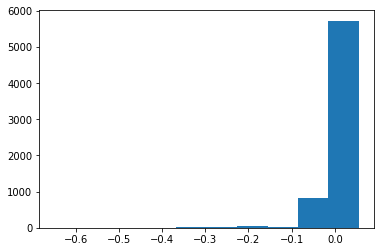

In [28]:
plt.hist(r2_transfer_seq)
plt.show()

In [29]:
np.mean(r2_transfer_seq)

-0.0017871750114164607

In [30]:
np.median(r2_transfer_seq)

0.0009393344753320099